This block contains helper methods and some regex patterns to use in the data extraction process.

In [106]:
from bs4 import Tag
from typing import Any
import re

# Helper function to flatten a 2D list into a 1D list
def flatten(matrix: list[list[Any]]) -> list[Any]:
    return [item for sublist in matrix for item in sublist]

# Regex patterns for sold house information
date_of_sale_pattern = re.compile(r"Såld (\d{1,2}) (januari|februari|mars|april|maj|juni|juli|augusti|september|oktober|november|december) (\d{4})")
address_pattern = re.compile(r"\b\w+(?:\s+\w+)*\s+\d{1,3}\b")
location_pattern = re.compile(r"\b\w+,\s+\w+\s+\w+\b")
bo_and_bi_area_pattern = re.compile(r"\b\d{2,3}+\s*(?:\+\s*\d+\s*)?\b")
nr_of_rooms_pattern = re.compile(r"\b\d+\s*rum\b")
area_of_plot_pattern = re.compile(r'\b\d{1,5}\b')
closing_price_pattern = re.compile(r"\b\d{1,3}(?: \d{3})* kr\b")

# What value to return if the information is not found
no_information = None

def find_sale_date(house_info: Tag) -> str | None:
    sale_date_str = no_information
    try:
        sale_date_str: str = re.findall(date_of_sale_pattern, house_info.text)[0]
        sale_date_str = f"{sale_date_str[0]} {sale_date_str[1]} {sale_date_str[2]}"
    except IndexError:
        pass
    return sale_date_str

def find_address(house_info: Tag) -> str | None:
    address_str = no_information
    try:
        address_tag: Tag = house_info.find_all("h2", class_="sold-property-listing__heading qa-selling-price-title hcl-card__title")[0]
        address_str = re.findall(address_pattern, address_tag.text)[0]
    except IndexError:
        pass
    return address_str

def find_location(house_info: Tag) -> str | None:
    location_str = no_information
    try:
        location_str: str = re.findall(location_pattern, house_info.text)[0]
        location_str = location_str.replace("\n","") \
                                    .replace("         ","")
    except IndexError:
        pass
    return location_str

def find_bo_and_bi_area(house_info: Tag) -> tuple[int] | None:
    bo_and_bi_area_int_tuple: tuple[int] = no_information
    try:
        bo_and_bi_area_tag: Tag = house_info.find_all("div", class_="sold-property-listing__subheading sold-property-listing__area")[0]
        bo_and_bi_area_str: str = bo_and_bi_area_tag.text.replace("\n","") \
                                                        .replace("         ","") \
                                                        .replace("  "," ") \
                                                        .replace(" ","") \
                                                        .replace(u"\xa0", u" ")
        bo_and_bi_area_str = re.findall(bo_and_bi_area_pattern, bo_and_bi_area_str)[0]
        bo_and_bi_area_str_list: list[str] = bo_and_bi_area_str.split("+")
        bo_and_bi_area_int_tuple = tuple([int(area) for area in bo_and_bi_area_str_list])
    except IndexError:
        pass
    return bo_and_bi_area_int_tuple

def find_nr_of_rooms(house_info: Tag) -> int | None:
    nr_of_rooms_int = no_information
    try:
        nr_of_rooms_tag: Tag = house_info.find_all("div", class_="sold-property-listing__subheading sold-property-listing__area")[0]
        nr_of_rooms_str: str = nr_of_rooms_tag.text.replace("\n","") \
                                                    .replace("         ","") \
                                                    .replace("  "," ") \
                                                    .replace(u"\xa0", u" ")                       
        nr_of_rooms_str = re.findall(nr_of_rooms_pattern, nr_of_rooms_str)[0]
        nr_of_rooms_str = nr_of_rooms_str.replace(" rum","")
        nr_of_rooms_int: int = int(nr_of_rooms_str)                     
    except IndexError:
        pass
    return nr_of_rooms_int

def find_closing_price(house_info: Tag) -> int | None:
    closing_price_str = no_information
    try:
        closing_price_tag: Tag = house_info.find_all("span", class_="hcl-text hcl-text--medium")[0]
        closing_price_str: str = closing_price_tag.text.replace(u"\xa0", u" ")
        closing_price_str = re.findall(closing_price_pattern, closing_price_str)[0]
        closing_price_str = closing_price_str.replace(" kr","")
        closing_price_str = closing_price_str.replace(" ","")
        closing_price_int: int = int(closing_price_str)
    except IndexError:
        pass
    return closing_price_int

def find_area_of_plot(house_info: Tag) -> int | None:
    area_of_plot_int = no_information
    try:
        area_of_plot_tag: Tag = house_info.find_all("div", class_="sold-property-listing__land-area")[0]
        area_of_plot_str: str = area_of_plot_tag.text.replace("\n","") \
                                                      .replace("         ","") \
                                                      .replace("  "," ") \
                                                      .replace(u"\xa0", u" ") \
                                                      .replace("m²","") \
                                                      .replace("tomt","") \
                                                      .replace(" ","") \

        area_of_plot_str = re.findall(area_of_plot_pattern, area_of_plot_str)[0]
        area_of_plot_int =int(area_of_plot_str) 
    except IndexError:
        pass
    return area_of_plot_int

# Helper function to extract sold house information from a Tag object (which is a list item) 
def get_sold_house_info(house_info: Tag) -> tuple[str, str, str, tuple[int], str, str, int]:

    sale_date_str: str = find_sale_date(house_info)
    address_str: str = find_address(house_info)
    location_str: str = find_location(house_info)
    bo_and_bi_area_str: tuple[int] = find_bo_and_bi_area(house_info)
    nr_of_rooms_int: int = find_nr_of_rooms(house_info)
    plot_area_str = find_area_of_plot(house_info)
    closing_price_int: int = find_closing_price(house_info)

    return (sale_date_str, address_str, location_str, bo_and_bi_area_str, nr_of_rooms_int, plot_area_str, closing_price_int)

### Problem 1: Scraping house prices

In [107]:
from bs4 import BeautifulSoup, ResultSet, Tag
import glob, os
import csv

# get all html files in the directory
dir_path = os.getcwd() + "/kungalv_slutpriser/*.html"
files = glob.glob(dir_path)
soups = [BeautifulSoup(open(file, encoding="utf-8"), "html.parser") for file in files]

# Find the list item html elements that contain the sold house information and extract the information using the helper functions
sold_houses_divs: list[ResultSet[Tag]] = [soup.find_all("li", class_ = "sold-results__normal-hit") for soup in soups]
sold_houses_divs: list[Tag] = flatten(sold_houses_divs)
houses_info: list[tuple] = [get_sold_house_info(house_info) for house_info in sold_houses_divs]

# Print the extracted information to a CSV file (Encoding iso-8859-1 is used to handle the Swedish characters)
if (os.path.exists("kungalv_sold_houses_data.csv")):
    os.remove("kungalv_sold_houses_data.csv")
with open("kungalv_sold_houses_data.csv", "w", newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Sale date", "Address", "Location", "Bo area", "Bi area", "Nr of rooms", "Plot area", "Closing price"])
    writer.writerows(houses_info)


### Problem 2: Analysing house prices
We decided to select the bins so that they envelope prices from the absolut lowest possible (0 kr) to the highest recorded price (10 500 000 kr).

Max closing price: 10500000
Min closing price: 1650000
Median closing price: 5000000.0
Mean closing price: 5076152.631578947
First quartile closing price: 4012500.0
Third quartile closing price: 5795000.0


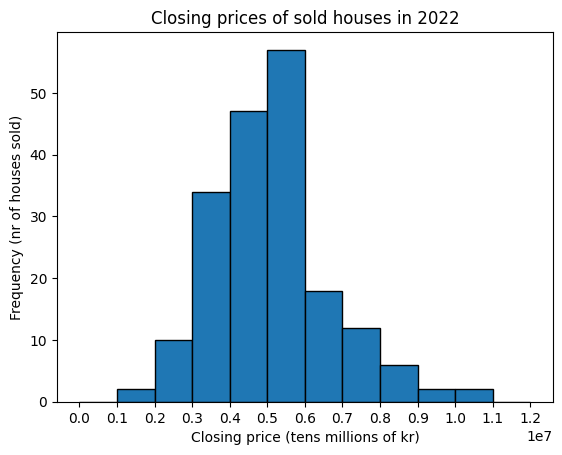

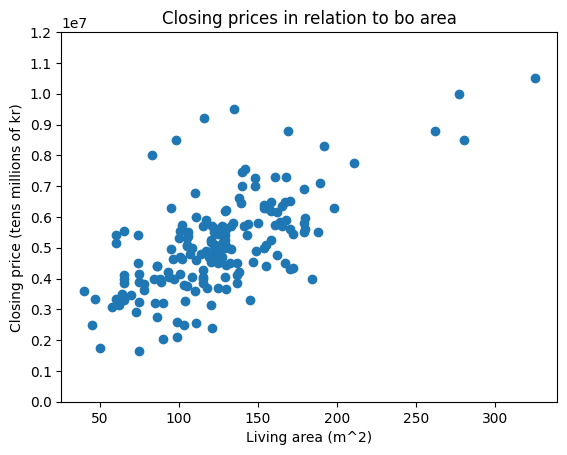

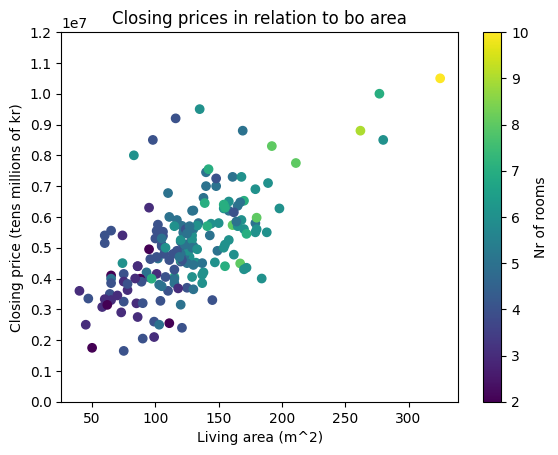

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a pandas dataframe from the sold house information
df = pd.DataFrame(houses_info, columns = ["Sale date", "Address", "Location", "Bo Bi area", "Nr of rooms", "Plot area", "Closing price"])
year_is_2022_pattern = "2022"
df_2022_info = df[df["Sale date"].str.contains(year_is_2022_pattern)]

max_closing_price = df_2022_info["Closing price"].max()
min_closing_price = df_2022_info["Closing price"].min()
median_closing_price = df_2022_info["Closing price"].median()
mean_closing_price = df_2022_info["Closing price"].mean()
first_quartile_closing_price = df_2022_info["Closing price"].quantile(0.25)
third_quartile_closing_price = df_2022_info["Closing price"].quantile(0.75)

# Print the max, min, mean, first quartile and third quartile closing prices of the sold houses in 2022
print(f"Max closing price: {max_closing_price}")
print(f"Min closing price: {min_closing_price}")
print(f"Median closing price: {median_closing_price}")
print(f"Mean closing price: {mean_closing_price}")
print(f"First quartile closing price: {first_quartile_closing_price}")
print(f"Third quartile closing price: {third_quartile_closing_price}")

# Plot the closing prices of the sold house in 2022 using histograms
bins = [0, 1e6, 2e6, 3e6, 4e6, 5e6, 6e6, 7e6, 8e6, 9e6, 1e7, 1.1e7, 1.2e7]
plt.hist(df_2022_info["Closing price"], bins = bins, edgecolor = "black")
plt.xlabel("Closing price (tens millions of kr)")
plt.xticks(bins)
plt.ylabel("Frequency (nr of houses sold)")
plt.title("Closing prices of sold houses in 2022")
plt.show()

# Cleaning the dataframe
df_2022_info = df_2022_info[df_2022_info["Bo Bi area"].notna()] # Remove houses with no bo area information
df_2022_info = df_2022_info[df_2022_info["Nr of rooms"].notna()] # Remove houses with no nr of rooms information

# Plot a scatter plot of the closing prices in relation to the bo area
plt.scatter(df_2022_info["Bo Bi area"].apply(lambda x: x[0]), df_2022_info["Closing price"]) # Use a lambda function to always select the first element of the tuple representing (bo area, bi area)
plt.xlabel("Living area (m^2)")
plt.yticks(bins)
plt.ylabel("Closing price (tens millions of kr)")
plt.title("Closing prices in relation to living area")
plt.show()

# Plot the same scatter plot but with the dots color coded by the number of rooms
plt.scatter(df_2022_info["Bo Bi area"].apply(lambda x: x[0]), df_2022_info["Closing price"], c = df_2022_info["Nr of rooms"])
plt.xlabel("Living area (m^2)")
plt.yticks(bins)
plt.ylabel("Closing price (tens millions of kr)")
plt.title("Closing prices in relation to living area")
plt.colorbar(label = "Nr of rooms")

### Discuss the figures.
The house prices we saw from the median, quartiles and histograms arent very suprising. The median we got was 5 000 000 kr (mean was very close by) which is a bit higher than the Swedish 2021 **mean** of 3 700 000 (acc [SCB](https://www.scb.se/hitta-statistik/redaktionellt/huspriser-stiger-i-stora-delar-av-landet/#:~:text=Snittpriset%20i%20Sverige%20f%C3%B6r%20en%20villa%2C%20ett%20radhus%C3%A5rsbasis%20%C3%A4r%20det%20en%20liknande%20prisutveckling%20f%C3%B6r%20fritidshus.))
but still smaller than the 2021 **mean** house price of Stockholm which was 6 700 000 kr which probably is a better comparison since the Kungälv area is quite urban.

Looking at the scatter plot we can, unsuprisingly, see that there seems to be a correlation between the amount of square meter living area and the price. Equally the amount of rooms seems to correlate. But since the amount of rooms probably correlates with the amount of square meter living area this is not very suprising either.

On interesting outlier that sadly got removed when we pruned away sold houses with no room information is the 28 square meter house going for around 7 000 000 kr. This is a very high price per square meter (250 000 kr) so we were a bit intrigued. Turns out however that this house was located on the Marstrand island which is a very exclusive and popular summer vacation spot. This is a good example of how the location of a house can greatly affect the price. 